In [1]:
# ============================================================
# 003_citation_network_data_collection
# ============================================================

# ⚠️ Important Notes (Please Read First)
# ------------------------------------
# - This notebook constructs a citation network starting from one or more seed papers
#   (the current implementation typically uses a single focal paper).
# - Citation data are collected via the OpenAlex API, primarily using the
#   `filter=cites:` endpoint to retrieve cited-by (forward citation) relationships.
# - Coverage of citation relationships may be incomplete or asymmetric:
#   older works, books, non-DOI publications, or non-indexed venues may be missing.
# - Citation links represent *declared citations*, not necessarily intellectual influence.
#   They should be interpreted as a structural signal, not a causal or normative measure.
# - OpenAlex API behavior (rate limits, pagination, available fields) may change over time.
#   When expanding the network, proceed incrementally and persist intermediate results.
# - The resulting citation network is intended for exploratory analysis
#   (e.g., identifying clusters, key nodes, or adjacent literatures),
#   not as a definitive or exhaustive map of a research field.

# Overview
# --------
# This notebook collects and structures citation relationships among academic works
# to build a directed citation network based on cited-by (forward citation) links.
#
# Starting from one or more seed papers, it retrieves:
# - Papers that cite the seed paper(s)
# - Papers that cite those papers, up to a configurable depth (BFS expansion)
#
# By relying on OpenAlex's `filter=cites:` API, this approach provides a stable and
# transparent way to trace how a focal work propagates through subsequent literature.
#
# The output is a graph-ready dataset (nodes and edges) that can be used for:
# - Mapping the structural neighborhood around a focal paper
# - Identifying highly cited or bridging works
# - Exploring related or previously overlooked literatures beyond keyword search
#
# This step complements keyword-based retrieval by leveraging citation structure
# rather than textual similarity alone.

# Structure
# ---------
# 1. Load seed paper(s) (title / DOI → OpenAlex work ID)
# 2. Retrieve cited-by relationships via OpenAlex API
#    - `filter=cites:` based retrieval
#    - rate-limit-aware pagination
# 3. Normalize and clean citation metadata
# 4. Construct node and edge tables via BFS expansion
# 5. Persist intermediate and final outputs for reuse
#    - JSON / CSV exports
#    - run manifest and optional checkpoints
#    - static (matplotlib) and interactive (PyVis) visualizations

# Notes
# -----
# - Treat the resulting network as a *research aid*, not ground truth.
# - For critical interpretation or citation, always verify key papers
#   using original publisher pages or PDFs.
# - Backward citation (references) retrieval can be added as an extension if needed,
#   but is intentionally excluded here to keep the expansion logic explicit and stable.
# - Downstream analysis (e.g., community detection, centrality measures,
#   or subfield clustering) is handled in subsequent notebooks.


In [2]:
# ============================================================
# 1. Load Seed Paper (Start Node)
# ============================================================
# This notebook starts from a single "root" paper and expands a citation network
# in the cited-by direction (papers that cite the root, then papers that cite those, ...).
#
# In this section we:
# - Accept a user query (paper title or DOI)
# - Search OpenAlex for candidate works
# - Let the user choose the start paper (root)
#
# Note:
# - OpenAlex "search" is not a strict match; we always show multiple candidates.
# - The selected root paper (OpenAlex work ID) will be used as the BFS start node.

import requests
import time
from pathlib import Path

# ===== Settings =====
OPENALEX_BASE_URL = "https://api.openalex.org"
REQUEST_SLEEP = 1.0  # seconds (rate-limit friendly)

# Data dir (raw exports)
DATA_DIR = Path("../data/raw")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Default target paper (Lerner 1999 SBIR)
DEFAULT_TITLE = "The Government as Venture Capitalist: The Long-Run Impact of the SBIR Program"

# Optional: add your email for nicer OpenAlex rate-limit handling (recommended)
# MAILTO = "you@example.com"
MAILTO = None

# ===== OpenAlex API Helpers =====
def openalex_get(path: str, params: dict | None = None) -> dict:
    url = f"{OPENALEX_BASE_URL}{path}"
    params = params or {}
    if MAILTO:
        params["mailto"] = MAILTO

    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    time.sleep(REQUEST_SLEEP)
    return r.json()


def normalize_openalex_work_id(openalex_id: str) -> str:
    """
    Normalize an OpenAlex work id to canonical URL form:
      - 'W123' -> 'https://openalex.org/W123'
      - 'https://openalex.org/W123' -> same
    """
    if openalex_id is None:
        return None
    openalex_id = openalex_id.strip()
    if openalex_id.startswith("http"):
        return openalex_id
    if openalex_id.startswith("W"):
        return f"https://openalex.org/{openalex_id}"
    return openalex_id  # fallback


def search_work_by_title_or_doi(query: str, per_page: int = 5) -> list[dict]:
    """
    Search OpenAlex works by:
      - DOI (if query looks like doi or contains 'doi.org/')
      - Otherwise: title search
    """
    q = query.strip()

    # DOI heuristics
    q_lower = q.lower()
    if "doi.org/" in q_lower:
        doi = q_lower.split("doi.org/")[-1].strip()
        params = {"filter": f"doi:{doi}"}
        data = openalex_get("/works", params=params)
        return data.get("results", [])

    if q_lower.startswith("10."):
        params = {"filter": f"doi:{q}"}
        data = openalex_get("/works", params=params)
        results = data.get("results", [])
        if results:
            return results  # DOI hit
        # If DOI filter fails, fall back to text search

    # Title / free-text search
    params = {"search": q, "per-page": per_page}
    data = openalex_get("/works", params=params)
    return data.get("results", [])


def get_work_by_openalex_id(openalex_id: str) -> dict:
    """
    Fetch a work object from OpenAlex given its ID (URL or Wxxxxx).
    """
    openalex_id = normalize_openalex_work_id(openalex_id)
    short_id = openalex_id.split("/")[-1]
    return openalex_get(f"/works/{short_id}")

# ===== User Input (title or DOI) =====
print("=== Citation Network Data Collection ===")
user_query = input(
    "Enter paper title or DOI (press Enter to use default)\n"
    f"Default: {DEFAULT_TITLE}\n> "
).strip()

if not user_query:
    user_query = DEFAULT_TITLE

print(f"\nSearch Query: {user_query}")

# ===== Determine Start Paper (candidates -> select) =====
candidates = search_work_by_title_or_doi(user_query, per_page=5)

if not candidates:
    raise ValueError("No matching works found in OpenAlex. Try a different query (title/DOI).")

print("\nCandidate Results:")
for i, w in enumerate(candidates):
    print(
        f"{i}: {w.get('id')}, "
        f"year={w.get('publication_year')}, "
        f"cited_by_count={w.get('cited_by_count')}, "
        f"title={w.get('display_name')}"
    )

# --- Selection strategy ---
# Default: take the first candidate, but allow manual override.
selected_idx_raw = input("\nSelect index (press Enter to use 0)\n> ").strip()
selected_idx = int(selected_idx_raw) if selected_idx_raw else 0

if selected_idx < 0 or selected_idx >= len(candidates):
    raise ValueError(f"Invalid index: {selected_idx}. Must be in [0, {len(candidates)-1}].")

root_work = candidates[selected_idx]
root_id = normalize_openalex_work_id(root_work["id"])
root_title = root_work.get("display_name")
root_year = root_work.get("publication_year")

print("\nSelected Start Paper:")
print(f"ID    : {root_id}")
print(f"Title : {root_title}")
print(f"Year  : {root_year}")
print(f"Cited-by count: {root_work.get('cited_by_count')}")

# Optional: fetch full record (sometimes candidates are partial-ish)
root_full = get_work_by_openalex_id(root_id)

root_full_summary = {
    "id": root_full.get("id"),
    "title": root_full.get("display_name"),
    "year": root_full.get("publication_year"),
    "cited_by_count": root_full.get("cited_by_count"),
    "host_venue": (root_full.get("host_venue") or {}).get("display_name"),
    "authors": [
        (a.get("author") or {}).get("display_name")
        for a in (root_full.get("authorships") or [])
    ],
}

root_full_summary


=== Citation Network Data Collection ===


Enter paper title or DOI (press Enter to use default)
Default: The Government as Venture Capitalist: The Long-Run Impact of the SBIR Program
>  



Search Query: The Government as Venture Capitalist: The Long-Run Impact of the SBIR Program

Candidate Results:
0: https://openalex.org/W3122760487, year=1999, cited_by_count=1130, title=The Government as Venture Capitalist: The Long‐Run Impact of the SBIR Program
1: https://openalex.org/W2168262427, year=1996, cited_by_count=279, title=The Government as Venture Capitalist: The Long-Run Impact of the SBIR Program
2: https://openalex.org/W3024096284, year=2000, cited_by_count=485, title=When Does Start-Up Innovation Spur the Gale of Creative Destruction?
3: https://openalex.org/W2167075895, year=2002, cited_by_count=163, title=Do Innovation Subsidies Crowd Out Private Investment? Evidence from the German Service Sector
4: https://openalex.org/W2576107905, year=2017, cited_by_count=120, title=Business incubation process and firm performance: an empirical review



Select index (press Enter to use 0)
>  



Selected Start Paper:
ID    : https://openalex.org/W3122760487
Title : The Government as Venture Capitalist: The Long‐Run Impact of the SBIR Program
Year  : 1999
Cited-by count: 1130


{'id': 'https://openalex.org/W3122760487',
 'title': 'The Government as Venture Capitalist: The Long‐Run Impact of the SBIR Program',
 'year': 1999,
 'cited_by_count': 1130,
 'host_venue': None,
 'authors': ['Josh Lerner']}

In [7]:
# ============================================================
# 2. Retrieve citation relationships via OpenAlex API
# ============================================================
# In this notebook, we expand the network in the "cited-by" direction:
#   (citing paper)  →  (cited paper)
#
# OpenAlex provides a reliable way to retrieve "works that cite X" by using:
#   /works?filter=cites:Wxxxx
#
# In this section we implement:
# - Robust "get citing works" function using filter=cites:
# - Pagination control (per-page, max_pages)
# - Optional sampling / truncation (max results per cited work)
# - A small normalization layer so downstream BFS stays clean
#
# Notes:
# - Pagination is necessary because highly cited papers can have many citing works.
# - Rate limiting is handled by REQUEST_SLEEP in openalex_get().

import random
from typing import Optional, Dict, Any, List

# ------------------------------------------------------------
# Helpers: extracting minimal node attributes from OpenAlex work objects
# ------------------------------------------------------------
def work_to_node_attrs(work: Dict[str, Any], depth: int) -> Dict[str, Any]:
    """
    Convert an OpenAlex work object to a compact node record.
    Keep it stable and JSON-serializable for downstream analysis/export.
    """
    return {
        "id": work.get("id"),
        "title": work.get("display_name"),
        "year": work.get("publication_year"),
        "cited_by_count": work.get("cited_by_count"),
        "host_venue": (work.get("host_venue") or {}).get("display_name"),
        "authorships": [
            (a.get("author") or {}).get("display_name")
            for a in (work.get("authorships") or [])
        ],
        "depth": depth,
    }

# ------------------------------------------------------------
# Core: Retrieve works that cite a given paper (filter=cites:)
# ------------------------------------------------------------
def get_citing_works_by_id(
    openalex_id: str,
    per_page: int = 50,
    max_pages: int = 3,
    max_total: Optional[int] = None,
    verbose: bool = True,
) -> List[Dict[str, Any]]:
    """
    Return a list of OpenAlex 'works' that cite the given OpenAlex work ID.

    Uses:
      GET /works?filter=cites:Wxxxx

    Args:
      openalex_id: full URL (https://openalex.org/W...) or short ID (W...)
      per_page: page size (max is typically 200; keep modest to be safe)
      max_pages: cap pagination for stability
      max_total: cap total results returned (applied after pagination)
      verbose: print per-page logs

    Returns:
      list of work objects (as returned by OpenAlex)
    """
    openalex_id = normalize_openalex_work_id(openalex_id)
    short_id = openalex_id.split("/")[-1]

    all_results: List[Dict[str, Any]] = []
    page = 1

    while page <= max_pages:
        params = {
            "filter": f"cites:{short_id}",
            "per-page": per_page,
            "page": page,
        }
        data = openalex_get("/works", params=params)
        results = data.get("results", []) or []

        all_results.extend(results)

        if verbose:
            print(f"  cites:{short_id} page {page}: {len(results)} results (accum={len(all_results)})")

        # Stop if this page was not full (no more pages)
        if len(results) < per_page:
            break

        # Stop if we hit max_total early
        if max_total is not None and len(all_results) >= max_total:
            break

        page += 1

    if max_total is not None:
        all_results = all_results[:max_total]

    return all_results

# ------------------------------------------------------------
# Optional: filter / sample citing works
# ------------------------------------------------------------
def filter_and_sample_citing_works(
    citing_works: List[Dict[str, Any]],
    min_cited_by: int = 0,
    max_citing_per_paper: Optional[int] = None,
    random_seed: int = 42,
    verbose: bool = True,
) -> List[Dict[str, Any]]:
    """
    Apply:
      - minimum cited_by_count threshold (quality / influence proxy)
      - optional truncation via sampling (to prevent explosion)
    """
    # threshold
    filtered = [
        w for w in citing_works
        if (w.get("cited_by_count") or 0) >= min_cited_by
    ]

    if verbose:
        print(f"  Filtered by min_cited_by={min_cited_by}: {len(filtered)} / {len(citing_works)}")

    # sample / cap
    if max_citing_per_paper is not None and len(filtered) > max_citing_per_paper:
        random.Random(random_seed).shuffle(filtered)
        filtered = filtered[:max_citing_per_paper]
        if verbose:
            print(f"  Capped to max_citing_per_paper={max_citing_per_paper}: {len(filtered)}")

    return filtered

# ------------------------------------------------------------
# Quick sanity check: retrieve citing works for root
# ------------------------------------------------------------
print("=== Sanity Check: citing works of root ===")
root_citing_raw = get_citing_works_by_id(
    root_id,
    per_page=50,
    max_pages=2,      # keep small for a quick check
    max_total=200,    # safety cap
    verbose=True
)

print(f"\nRaw citing works retrieved: {len(root_citing_raw)}")

root_citing_filtered = filter_and_sample_citing_works(
    root_citing_raw,
    min_cited_by=0,
    max_citing_per_paper=20,
    verbose=True
)

print(f"\nFiltered citing works: {len(root_citing_filtered)}")

# Show a few examples
for w in root_citing_filtered[:5]:
    print(f"- {w.get('publication_year')} | {w.get('cited_by_count')} cites | {w.get('display_name')}")


=== Sanity Check: citing works of root ===
  cites:W3122760487 page 1: 50 results (accum=50)
  cites:W3122760487 page 2: 50 results (accum=100)

Raw citing works retrieved: 100
  Filtered by min_cited_by=0: 100 / 100
  Capped to max_citing_per_paper=20: 20

Filtered citing works: 20
- 2008 | 320 cites | Two for the price of one?
- 2014 | 332 cites | Government, venture capital and the growth of European high-tech entrepreneurial firms
- 2006 | 146 cites | Cluster Genesis
- 2015 | 698 cites | The impact of R&amp;D subsidies on firm innovation
- 2008 | 207 cites | Pathways to the entrepreneurial university: towards a global convergence


In [8]:
# ============================================================
# 3. Normalize and Clean Citation Metadata
# ============================================================
# OpenAlex work objects contain rich but nested metadata and may vary by record.
# For network construction and downstream analysis, we normalize them into a
# stable, compact schema for:
# - Nodes (works)
# - Edges (citing -> cited)
#
# This section defines:
# - ID normalization utilities (OpenAlex URL <-> short id)
# - Safe extraction (nested fields, missing values)
# - Canonical node schema + coercions (types, defaults)
# - Lightweight cleaning (strings, years, author lists)
#
# Output of this section is used by BFS + JSON exports.

import re
from typing import Tuple

# ------------------------------------------------------------
# ID utilities
# ------------------------------------------------------------
def openalex_short_id(openalex_id: str) -> str:
    """https://openalex.org/W123 -> W123"""
    if openalex_id is None:
        return None
    openalex_id = openalex_id.strip()
    return openalex_id.split("/")[-1]


def openalex_url(short_or_url: str) -> str:
    """W123 -> https://openalex.org/W123 ; url stays url."""
    if short_or_url is None:
        return None
    x = short_or_url.strip()
    if x.startswith("http"):
        return x
    if x.startswith("W"):
        return f"https://openalex.org/{x}"
    return x

# ------------------------------------------------------------
# Safe parsing / cleaning helpers
# ------------------------------------------------------------
def clean_str(x):
    if x is None:
        return None
    if isinstance(x, str):
        x = x.strip()
        return x if x != "" else None
    return str(x).strip()


def safe_int(x):
    try:
        if x is None:
            return None
        return int(x)
    except Exception:
        return None


def safe_list(x):
    if x is None:
        return []
    return x if isinstance(x, list) else [x]


def extract_host_venue_name(work: dict) -> str:
    hv = work.get("host_venue") or {}
    return clean_str(hv.get("display_name"))


def extract_authors(work: dict, max_authors: int = 25) -> list[str]:
    authorships = work.get("authorships") or []
    names = []
    for a in authorships:
        author = a.get("author") or {}
        n = clean_str(author.get("display_name"))
        if n:
            names.append(n)
        if len(names) >= max_authors:
            break
    return names

# ------------------------------------------------------------
# Canonical Node schema
# ------------------------------------------------------------
NODE_SCHEMA_KEYS = [
    "id",               # canonical OpenAlex URL
    "short_id",         # Wxxxx
    "title",
    "year",
    "cited_by_count",
    "host_venue",
    "authors",          # list[str]
    "depth",            # int
]

def normalize_node(work: dict, depth: int) -> dict:
    """
    Normalize an OpenAlex work object into a compact node record.
    """
    oid = work.get("id")
    oid = openalex_url(oid) if oid else None

    node = {
        "id": oid,
        "short_id": openalex_short_id(oid) if oid else None,
        "title": clean_str(work.get("display_name")),
        "year": safe_int(work.get("publication_year")),
        "cited_by_count": safe_int(work.get("cited_by_count")) or 0,
        "host_venue": extract_host_venue_name(work),
        "authors": extract_authors(work),
        "depth": safe_int(depth) or 0,
    }
    return node

# ------------------------------------------------------------
# Canonical Edge schema
# ------------------------------------------------------------
EDGE_SCHEMA_KEYS = ["source", "target"]

def normalize_edge(source_id: str, target_id: str) -> dict:
    """
    Edge: source (citing) -> target (cited)
    """
    return {
        "source": openalex_url(source_id),
        "target": openalex_url(target_id),
    }

# ------------------------------------------------------------
# Optional: integrity checks and dedup helpers
# ------------------------------------------------------------
def validate_node(node: dict) -> Tuple[bool, str]:
    if not node.get("id"):
        return False, "missing id"
    if not node.get("short_id") or not node["short_id"].startswith("W"):
        return False, "invalid short_id"
    return True, ""


def dedup_edges(edges: list[dict]) -> list[dict]:
    seen = set()
    out = []
    for e in edges:
        k = (e.get("source"), e.get("target"))
        if None in k:
            continue
        if k in seen:
            continue
        seen.add(k)
        out.append(e)
    return out

# ------------------------------------------------------------
# Sanity check on a small set (root + its citing works)
# ------------------------------------------------------------
print("=== Normalize sanity check ===")

# root_full (Section 1) is a full record; root_citing_filtered (Section 2) are citing works
root_node = normalize_node(root_full, depth=0)

citing_nodes = [normalize_node(w, depth=1) for w in root_citing_filtered]
edges = [normalize_edge(w["id"], root_id) for w in root_citing_filtered]  # citing -> root

# Validate
ok, msg = validate_node(root_node)
print("root_node valid:", ok, msg)

bad = 0
for n in citing_nodes:
    ok, msg = validate_node(n)
    if not ok:
        bad += 1

print(f"citing_nodes: {len(citing_nodes)} (invalid={bad})")
print(f"edges (raw): {len(edges)}")

edges = dedup_edges(edges)
print(f"edges (deduped): {len(edges)}")

# Preview
root_node, citing_nodes[:2], edges[:2]


=== Normalize sanity check ===
root_node valid: True 
citing_nodes: 20 (invalid=0)
edges (raw): 20
edges (deduped): 20


({'id': 'https://openalex.org/W3122760487',
  'short_id': 'W3122760487',
  'title': 'The Government as Venture Capitalist: The Long‐Run Impact of the SBIR Program',
  'year': 1999,
  'cited_by_count': 1130,
  'host_venue': None,
  'authors': ['Josh Lerner'],
  'depth': 0},
 [{'id': 'https://openalex.org/W2069320932',
   'short_id': 'W2069320932',
   'title': 'Two for the price of one?',
   'year': 2008,
   'cited_by_count': 320,
   'host_venue': None,
   'authors': ['Kris Aerts', 'Tobias Schmidt'],
   'depth': 1},
  {'id': 'https://openalex.org/W3121264934',
   'short_id': 'W3121264934',
   'title': 'Government, venture capital and the growth of European high-tech entrepreneurial firms',
   'year': 2014,
   'cited_by_count': 332,
   'host_venue': None,
   'authors': ['Luca Grilli', 'Samuele Murtinu'],
   'depth': 1}],
 [{'source': 'https://openalex.org/W2069320932',
   'target': 'https://openalex.org/W3122760487'},
  {'source': 'https://openalex.org/W3121264934',
   'target': 'https://

In [9]:
# ============================================================
# 4. Construct Node and Edge Tables for Network Analysis
# ============================================================
# We now build the citation network using BFS expansion in the cited-by direction.
#
# Direction:
#   (citing work)  ->  (cited work)
#
# BFS layers:
#   depth 0: root
#   depth 1: works that cite root
#   depth 2: works that cite depth-1 works
#
# This section constructs:
# - nodes: dict[id] -> normalized node attributes
# - edges: list[{source, target}] (citing -> cited)
#
# We also:
# - track visited work IDs to avoid infinite loops / duplicates
# - apply thresholding (min_cited_by) and caps (max_citing_per_paper)
# - keep verbose logs to monitor network growth

from collections import deque
import math
import pandas as pd

# ------------------------------------------------------------
# BFS crawler: cited-by direction (uses filter=cites:)
# ------------------------------------------------------------
def crawl_cited_by_bfs(
    root_openalex_id: str,
    max_depth: int = 2,
    min_cited_by: int = 0,
    max_citing_per_paper: int | None = 50,
    per_page: int = 50,
    max_pages: int = 3,
    random_seed: int = 42,
    verbose: bool = True,
):
    """
    Build a citation network by BFS in cited-by direction.

    Nodes: works (normalized)
    Edges: citing -> cited

    Args:
      root_openalex_id: start paper (OpenAlex URL or Wxxx)
      max_depth: BFS depth (0=root, 1=citers of root, ...)
      min_cited_by: filter citing works by cited_by_count >= this
      max_citing_per_paper: cap number of citing works per cited paper (sampling)
      per_page, max_pages: OpenAlex pagination controls for cites:
      random_seed: sampling reproducibility
      verbose: print logs

    Returns:
      nodes_dict: {openalex_url: node_dict}
      edges_list: [edge_dict]
    """
    root_openalex_id = openalex_url(root_openalex_id)

    # queue holds (work_id, depth)
    q = deque([(root_openalex_id, 0)])
    visited = set([root_openalex_id])

    nodes: dict[str, dict] = {}
    edges: list[dict] = []

    # Ensure root node exists (full fetch for better metadata)
    if verbose:
        print(f"\n[Init] Fetch root: {root_openalex_id}")
    root_work = get_work_by_openalex_id(root_openalex_id)
    nodes[root_openalex_id] = normalize_node(root_work, depth=0)

    while q:
        current_id, depth = q.popleft()

        if verbose:
            print(f"\n[BFS] depth={depth} current={current_id}")

        if depth >= max_depth:
            if verbose:
                print("  Reached max_depth; skip expansion.")
            continue

        # --- Retrieve citing works (raw) ---
        citing_raw = get_citing_works_by_id(
            current_id,
            per_page=per_page,
            max_pages=max_pages,
            max_total=None,
            verbose=verbose
        )

        if verbose:
            print(f"  citing_raw: {len(citing_raw)}")

        # --- Filter + sample citing works ---
        citing_filtered = filter_and_sample_citing_works(
            citing_raw,
            min_cited_by=min_cited_by,
            max_citing_per_paper=max_citing_per_paper,
            random_seed=random_seed,
            verbose=verbose
        )

        if verbose:
            print(f"  citing_filtered: {len(citing_filtered)}")

        # --- Register nodes + edges ---
        next_depth = depth + 1

        for citing_work in citing_filtered:
            citing_id = openalex_url(citing_work.get("id"))
            if citing_id is None:
                continue

            # Edge: citing -> current
            edges.append(normalize_edge(citing_id, current_id))

            # Node: citing work
            if citing_id not in nodes:
                # candidates are often sufficient; do not refetch unless needed
                nodes[citing_id] = normalize_node(citing_work, depth=next_depth)
            else:
                # keep minimal depth if we discover a shorter path
                if nodes[citing_id].get("depth", math.inf) > next_depth:
                    nodes[citing_id]["depth"] = next_depth

            # BFS continue
            if citing_id not in visited:
                visited.add(citing_id)
                q.append((citing_id, next_depth))

        if verbose:
            print(f"  nodes so far: {len(nodes)} | edges so far: {len(edges)} | queue: {len(q)}")

    # Dedup edges at end
    edges = dedup_edges(edges)

    if verbose:
        print("\n[Done]")
        print(f"  nodes: {len(nodes)}")
        print(f"  edges: {len(edges)}")

    return nodes, edges

# ------------------------------------------------------------
# Run a small extraction (non-interactive baseline)
# ------------------------------------------------------------
MAX_DEPTH = 2
MIN_CITED_BY_THRESHOLD = 1000
MAX_CITING_PER_PAPER = 10

nodes, edges = crawl_cited_by_bfs(
    root_openalex_id=root_id,
    max_depth=MAX_DEPTH,
    min_cited_by=MIN_CITED_BY_THRESHOLD,
    max_citing_per_paper=MAX_CITING_PER_PAPER,
    per_page=50,
    max_pages=3,
    random_seed=42,
    verbose=True,
)

print(f"\nResult: nodes={len(nodes)}, edges={len(edges)}")

# ------------------------------------------------------------
# Convert to "tables" (DataFrame) for analysis convenience
# ------------------------------------------------------------
nodes_df = pd.DataFrame(list(nodes.values()))
edges_df = pd.DataFrame(edges)

print("nodes_df:", nodes_df.shape)
print("edges_df:", edges_df.shape)

nodes_df.head(), edges_df.head()

# ------------------------------------------------------------
# Basic integrity checks
# ------------------------------------------------------------
# 1) Edge endpoints exist in nodes
missing_src = set(edges_df["source"]) - set(nodes_df["id"])
missing_tgt = set(edges_df["target"]) - set(nodes_df["id"])

print(f"Missing source nodes: {len(missing_src)}")
print(f"Missing target nodes: {len(missing_tgt)}")

# 2) Depth distribution
nodes_df["depth"].value_counts().sort_index()



[Init] Fetch root: https://openalex.org/W3122760487

[BFS] depth=0 current=https://openalex.org/W3122760487
  cites:W3122760487 page 1: 50 results (accum=50)
  cites:W3122760487 page 2: 50 results (accum=100)
  cites:W3122760487 page 3: 50 results (accum=150)
  citing_raw: 150
  Filtered by min_cited_by=1000: 8 / 150
  citing_filtered: 8
  nodes so far: 9 | edges so far: 8 | queue: 8

[BFS] depth=1 current=https://openalex.org/W1553746973
  cites:W1553746973 page 1: 50 results (accum=50)
  cites:W1553746973 page 2: 50 results (accum=100)
  cites:W1553746973 page 3: 50 results (accum=150)
  citing_raw: 150
  Filtered by min_cited_by=1000: 3 / 150
  citing_filtered: 3
  nodes so far: 12 | edges so far: 11 | queue: 10

[BFS] depth=1 current=https://openalex.org/W2038765589
  cites:W2038765589 page 1: 50 results (accum=50)
  cites:W2038765589 page 2: 50 results (accum=100)
  cites:W2038765589 page 3: 50 results (accum=150)
  citing_raw: 150
  Filtered by min_cited_by=1000: 1 / 150
  citin

depth
0     1
1     8
2    22
Name: count, dtype: int64

Saved manifest: artifacts/citationnet_root_W3122760487_m1000_k10_d2.manifest.json
Saved JSON:
  artifacts/citationnet_root_W3122760487_m1000_k10_d2.nodes.json
  artifacts/citationnet_root_W3122760487_m1000_k10_d2.edges.json
Saved CSV:
  artifacts/citationnet_root_W3122760487_m1000_k10_d2.nodes.csv
  artifacts/citationnet_root_W3122760487_m1000_k10_d2.edges.csv
=== Static Visualization ===


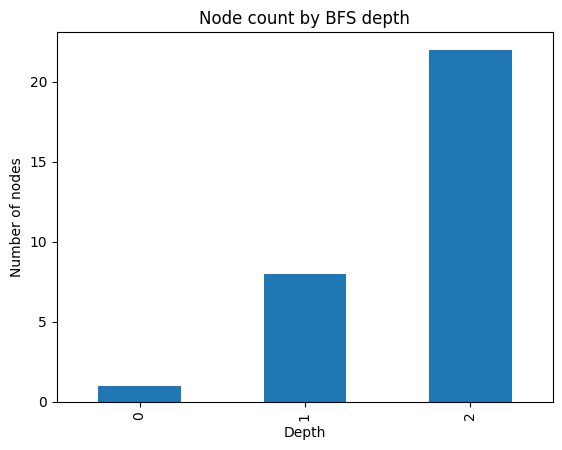

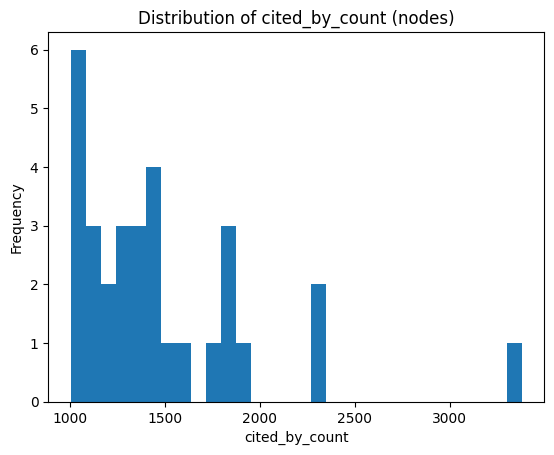

=== Interactive Visualization (PyVis, depth colors + more spacing) ===
Saved PyVis HTML: artifacts/citationnet_root_W3122760487_m1000_k10_d2.pyvis.depth_colors.spread.html


In [10]:
# ============================================================
# 5. Persist Intermediate and Final Outputs for Reuse
# ============================================================
# This section persists:
# - Final outputs: nodes / edges (JSON + CSV)
# - Run metadata (parameters, root paper info, timestamp)
# - Optional checkpoints (to resume / debug long crawls)
#
# Design goals:
# - Reproducibility: keep a manifest of parameters + root work
# - Restartability: avoid re-crawling by saving artifacts
# - Interoperability: JSON for graphs, CSV for quick inspection

import json
from datetime import datetime, timezone

# ------------------------------------------------------------
# Output directory + naming
# ------------------------------------------------------------
ARTIFACTS_DIR = Path("./artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Parameter-based prefix (matches your original style)
run_prefix = (
    f"citationnet_root_{openalex_short_id(root_id)}"
    f"_m{MIN_CITED_BY_THRESHOLD}"
    f"_k{MAX_CITING_PER_PAPER}"
    f"_d{MAX_DEPTH}"
)

OUT_PREFIX = ARTIFACTS_DIR / run_prefix
OUT_PREFIX

# ------------------------------------------------------------
# Manifest (run metadata)
# ------------------------------------------------------------
run_manifest = {
    "created_at_utc": datetime.now(timezone.utc).isoformat(),
    "openalex_base_url": OPENALEX_BASE_URL,
    "request_sleep_sec": REQUEST_SLEEP,
    "root": {
        "id": openalex_url(root_id),
        "short_id": openalex_short_id(root_id),
        "title": root_title,
        "year": root_year,
        "cited_by_count": root_work.get("cited_by_count") if isinstance(root_work, dict) else None,
    },
    "params": {
        "max_depth": MAX_DEPTH,
        "min_cited_by": MIN_CITED_BY_THRESHOLD,
        "max_citing_per_paper": MAX_CITING_PER_PAPER,
        "per_page": 50,
        "max_pages": 3,
        "random_seed": 42,
        "mailto": MAILTO,
    },
    "counts": {
        "nodes": len(nodes),
        "edges": len(edges),
    },
}

manifest_path = OUT_PREFIX.with_suffix(".manifest.json")
with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(run_manifest, f, ensure_ascii=False, indent=2)

print(f"Saved manifest: {manifest_path}")

# ------------------------------------------------------------
# Save FINAL outputs (JSON)
# ------------------------------------------------------------
nodes_json_path = OUT_PREFIX.with_suffix(".nodes.json")
edges_json_path = OUT_PREFIX.with_suffix(".edges.json")

with open(nodes_json_path, "w", encoding="utf-8") as f:
    json.dump(nodes, f, ensure_ascii=False, indent=2)

with open(edges_json_path, "w", encoding="utf-8") as f:
    json.dump(edges, f, ensure_ascii=False, indent=2)

print("Saved JSON:")
print(f"  {nodes_json_path}")
print(f"  {edges_json_path}")

# ------------------------------------------------------------
# Save FINAL outputs (CSV) for quick inspection
# ------------------------------------------------------------
nodes_csv_path = OUT_PREFIX.with_suffix(".nodes.csv")
edges_csv_path = OUT_PREFIX.with_suffix(".edges.csv")

nodes_df.to_csv(nodes_csv_path, index=False)
edges_df.to_csv(edges_csv_path, index=False)

print("Saved CSV:")
print(f"  {nodes_csv_path}")
print(f"  {edges_csv_path}")

# ------------------------------------------------------------
# Optional: Lightweight checkpoint utility (for long crawls)
# ------------------------------------------------------------
def save_checkpoint(
    nodes_dict: dict,
    edges_list: list,
    prefix: Path,
    tag: str,
    extra: dict | None = None
):
    """
    Save an intermediate checkpoint:
      - nodes / edges snapshots
      - small checkpoint manifest
    """
    ts = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
    ckpt_prefix = Path(str(prefix) + f".ckpt_{tag}_{ts}")

    ckpt_manifest = {
        "created_at_utc": datetime.now(timezone.utc).isoformat(),
        "tag": tag,
        "counts": {"nodes": len(nodes_dict), "edges": len(edges_list)},
    }
    if extra:
        ckpt_manifest["extra"] = extra

    with open(ckpt_prefix.with_suffix(".manifest.json"), "w", encoding="utf-8") as f:
        json.dump(ckpt_manifest, f, ensure_ascii=False, indent=2)

    with open(ckpt_prefix.with_suffix(".nodes.json"), "w", encoding="utf-8") as f:
        json.dump(nodes_dict, f, ensure_ascii=False)

    with open(ckpt_prefix.with_suffix(".edges.json"), "w", encoding="utf-8") as f:
        json.dump(edges_list, f, ensure_ascii=False)

    print(f"[checkpoint saved] {ckpt_prefix}")
    return ckpt_prefix

# Example usage (uncomment if needed):
# save_checkpoint(nodes, edges, OUT_PREFIX, tag="after_bfs")

# ------------------------------------------------------------
# Reload helper (for reuse without re-crawling)
# ------------------------------------------------------------
def load_saved_graph(prefix: Path):
    """
    Load nodes/edges back from JSON exports.
    Returns: (nodes_dict, edges_list, nodes_df, edges_df)
    """
    with open(prefix.with_suffix(".nodes.json"), "r", encoding="utf-8") as f:
        nodes_dict = json.load(f)

    with open(prefix.with_suffix(".edges.json"), "r", encoding="utf-8") as f:
        edges_list = json.load(f)

    nodes_df = pd.DataFrame(list(nodes_dict.values()))
    edges_df = pd.DataFrame(edges_list)
    return nodes_dict, edges_list, nodes_df, edges_df

# Example usage (uncomment if needed):
# nodes2, edges2, nodes_df2, edges_df2 = load_saved_graph(OUT_PREFIX)
# print(len(nodes2), len(edges2))

# ------------------------------------------------------------
# Visualization (Static + Interactive)
# ------------------------------------------------------------
# We provide two quick visualizations:
# 1) Static overview (matplotlib): network size by depth + cited_by distribution
# 2) Interactive graph (PyVis): explore nodes/edges in the browser
#
# Notes:
# - For large graphs, visualization may be slow; consider lowering max_depth
#   or max_citing_per_paper, or increasing min_cited_by threshold.
# - PyVis output is saved as an HTML file under artifacts/ for easy sharing.

import matplotlib.pyplot as plt

# ------------------------------------------------------------
# (A) Static visualization with matplotlib
# ------------------------------------------------------------
print("=== Static Visualization ===")

# 1) Node count by depth
depth_counts = nodes_df["depth"].value_counts().sort_index()
plt.figure()
depth_counts.plot(kind="bar")
plt.title("Node count by BFS depth")
plt.xlabel("Depth")
plt.ylabel("Number of nodes")
plt.show()

# 2) cited_by_count distribution (log-ish scale via clipping to keep readable)
#    (matplotlib only; avoid seaborn per project conventions)
cited = nodes_df["cited_by_count"].fillna(0).astype(int)
plt.figure()
plt.hist(cited, bins=30)
plt.title("Distribution of cited_by_count (nodes)")
plt.xlabel("cited_by_count")
plt.ylabel("Frequency")
plt.show()
# ------------------------------------------------------------
# Improved node sizing for PyVis
# ------------------------------------------------------------
def node_size_from_citations(cited_by_count: int, depth: int) -> int:
    """
    Compute a visually balanced node size for PyVis.
    - log-scale by cited_by_count
    - boost root node
    """
    cbc = cited_by_count or 0

    # Base size: log-scaled
    size = 10 + 8 * math.log10(cbc + 1)

    # Emphasize root
    if depth == 0:
        size *= 1.8

    return int(size)

# ------------------------------------------------------------
# (B) Interactive visualization with PyVis (clean labels & tooltips)
# ------------------------------------------------------------
print("=== Interactive Visualization (PyVis, depth colors + more spacing) ===")

try:
    from pyvis.network import Network
    from IPython.display import IFrame, display
    import math
    import pandas as pd

    # --- depth -> color palette (adjust freely) ---
    DEPTH_COLORS = {
        0: "#d62728",  # root (red)
        1: "#1f77b4",  # depth 1 (blue)
        2: "#2ca02c",  # depth 2 (green)
        3: "#ff7f0e",  # depth 3 (orange)
        4: "#9467bd",  # depth 4 (purple)
    }
    DEFAULT_COLOR = "#7f7f7f"  # gray for depth>=5 or missing

    net = Network(
        height="820px",
        width="100%",
        directed=True,
        notebook=True,
        cdn_resources="in_line",
    )

    # Physics: spread nodes out more
    # - springLength ↑ : longer edges -> more spacing
    # - gravitationalConstant abs ↓ : weaker pull -> more spread
    # - avoidOverlap ↑ : reduce collisions/overlap
    net.set_options("""
    {
      "interaction": { "hover": true, "tooltipDelay": 80 },
      "nodes": {
        "shape": "dot",
        "font": { "size": 14, "face": "arial" }
      },
      "edges": {
        "arrows": { "to": { "enabled": true, "scaleFactor": 0.7 } },
        "smooth": { "type": "dynamic" }
      },
      "physics": {
        "enabled": true,
        "solver": "barnesHut",
        "barnesHut": {
          "gravitationalConstant": -7000,
          "centralGravity": 0.05,
          "springLength": 240,
          "springConstant": 0.03,
          "avoidOverlap": 1.0
        },
        "minVelocity": 0.5
      }
    }
    """)

    def node_size_from_citations(cited_by_count: int, depth: int) -> int:
        cbc = cited_by_count or 0
        size = 16 + 10 * math.log10(cbc + 1)  # a bit larger baseline
        if depth == 0:
            size *= 1.9
        return int(size)

    for _, row in nodes_df.iterrows():
        nid = row["id"]
        title_full = row.get("title") or ""
        year = row.get("year")
        cbc = row.get("cited_by_count", 0)
        venue = row.get("host_venue") or ""
        depth = int(row.get("depth", 0) or 0)

        # label: keep shorter to reduce clutter
        label = title_full[:38] + "…" if len(title_full) > 38 else title_full

        # tooltip: plain text with newlines (stable)
        tooltip_text = "\n".join([
            title_full,
            f"Year: {year}",
            f"Cited-by: {cbc}",
            f"Venue: {venue}",
            f"Depth: {depth}",
            f"ID: {nid}",
        ])

        color = DEPTH_COLORS.get(depth, DEFAULT_COLOR)

        net.add_node(
            nid,
            label=label,
            title=tooltip_text,
            size=node_size_from_citations(cbc, depth),
            color=color,   # ✅ depth-based color
        )

    for _, e in edges_df.iterrows():
        src = e["source"]
        tgt = e["target"]
        if pd.isna(src) or pd.isna(tgt):
            continue
        net.add_edge(src, tgt)

    pyvis_path = OUT_PREFIX.with_suffix(".pyvis.depth_colors.spread.html")
    net.write_html(str(pyvis_path))

    print(f"Saved PyVis HTML: {pyvis_path}")
    display(IFrame(src=str(pyvis_path), width="100%", height="880px"))

except Exception as e:
    print("PyVis visualization skipped.")
    print("Error:", repr(e))


